In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/archive.zip -d /content/isic2019

Streaming output truncated to the last 5000 lines.
  inflating: /content/isic2019/train-image/image/ISIC_0065357.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065358.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065359.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065360.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065361.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065362.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065366.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065367.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065368.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065370.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065371.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065372.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065374.jpg  
  inflating: /content/isic2019/train-image/image/ISIC_0065376.jpg

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [4]:
!ls /content/isic2019

train-image  train-metadata.csv


In [5]:
import pandas as pd

df = pd.read_csv('/content/isic2019/train-metadata.csv')
df.head()

,Unnamed: 0,isic_id,patient_id,target
0,0,ISIC_0000000,dummy_0,0
1,1,ISIC_0000001,dummy_1,0
2,2,ISIC_0000002,dummy_2,1
3,3,ISIC_0000003,dummy_3,0
4,4,ISIC_0000004,dummy_4,1


In [6]:
# image directory path
image_dir = '/content/isic2019/train-image/'

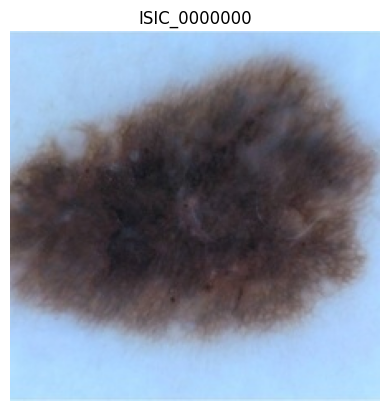

In [7]:
import cv2
import matplotlib.pyplot as plt
import os

sample_img = df.iloc[0]['isic_id']
img_path = os.path.join(image_dir, 'image', sample_img + '.jpg')
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(sample_img)
plt.axis('off')
plt.show()

In [8]:
import cv2
import os

image_dir = '/content/isic2019/train-image/image/'

for i, img_name in enumerate(df['isic_id'][:10]):  # check first 10 images
    img_path = os.path.join(image_dir, img_name + '.jpg')  # add extension if needed
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found or corrupted: {img_name}")
        continue
    print(f"{img_name}: {img.shape}")  # shape = (height, width, channels)

ISIC_0000000: (224, 224, 3)
ISIC_0000001: (224, 224, 3)
ISIC_0000002: (224, 224, 3)
ISIC_0000003: (224, 224, 3)
ISIC_0000004: (224, 224, 3)
ISIC_0000006: (224, 224, 3)
ISIC_0000007: (224, 224, 3)
ISIC_0000008: (224, 224, 3)
ISIC_0000009: (224, 224, 3)
ISIC_0000010: (224, 224, 3)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  25331 non-null  int64 
 1   isic_id     25331 non-null  object
 2   patient_id  25331 non-null  object
 3   target      25331 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 791.7+ KB


In [10]:
df.isnull().sum()

,0
Unnamed: 0,0
isic_id,0
patient_id,0
target,0


In [11]:
df['target'].value_counts()

,count
target,
0,20809
1,4522


/tmp/ipython-input-12-954216476.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='mako')


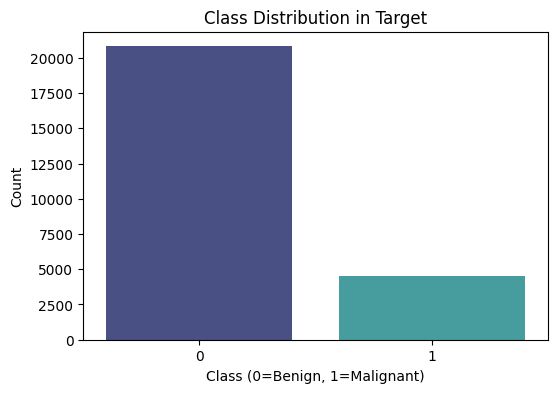

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df, palette='mako')
plt.title('Class Distribution in Target')
plt.xlabel('Class (0=Benign, 1=Malignant)')  # Adjust if different meaning
plt.ylabel('Count')
plt.show()

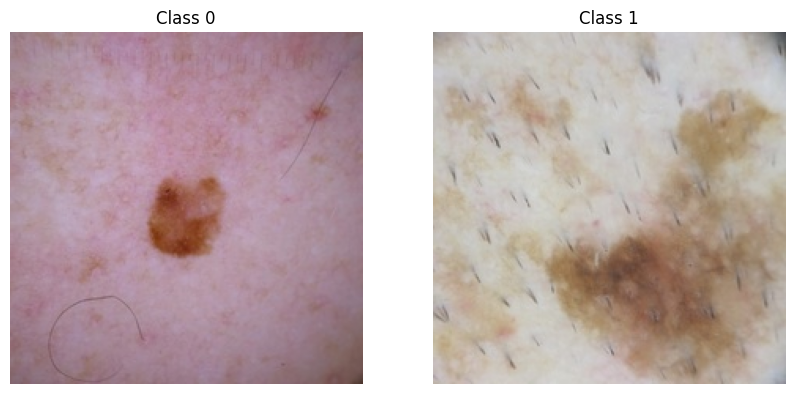

In [13]:
image_dir = '/content/isic2019/train-image/image/'

plt.figure(figsize=(10,5))

# Plot samples for both classes (assuming binary classification 0 and 1)
for i, label in enumerate(df['target'].unique()):
    sample = df[df['target'] == label].sample(1)
    img_path = os.path.join(image_dir, sample.iloc[0]['isic_id'] + '.jpg')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(f"Class {label}")
    plt.axis('off')

plt.show()

In [14]:
print("Number of unique patients:", df['patient_id'].nunique())

print("Patients per class:")
print(df.groupby('target')['patient_id'].nunique())

Number of unique patients: 25331
Patients per class:
target
0    20809
1     4522
Name: patient_id, dtype: int64


In [15]:
patients = df['patient_id'].unique()

In [16]:
train_patients, temp_patients = train_test_split(patients, test_size=0.3, random_state=42)

In [17]:
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

In [44]:
train_df = df[df['patient_id'].isin(train_patients)].copy()
val_df = df[df['patient_id'].isin(val_patients)].copy()
test_df = df[df['patient_id'].isin(test_patients)].copy()

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 17731
Validation samples: 3800
Test samples: 3800


In [52]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True
)


datagen_val = ImageDataGenerator(rescale=1./255)

# Add 'path' column to dataframes
image_dir = '/content/isic2019/train-image/image/'
train_df['path'] = train_df['isic_id'].apply(lambda x: os.path.join(image_dir, x + '.jpg'))
val_df['path'] = val_df['isic_id'].apply(lambda x: os.path.join(image_dir, x + '.jpg'))

# Convert target column to string for categorical class_mode
train_df['target'] = train_df['target'].astype(str)
val_df['target'] = val_df['target'].astype(str)


train_generator = datagen_train.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='target',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen_val.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='target',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 24774 validated image filenames belonging to 2 classes.
Found 4372 validated image filenames belonging to 2 classes.


In [20]:


# Check unique values and sample some entries in the 'isic_id' column
print("Unique values in 'isic_id' column:", df['isic_id'].nunique())
print("\nSample 'isic_id' values:")
print(df['isic_id'].sample(10).tolist())

Unique values in 'isic_id' column: 25331

Sample 'isic_id' values:
['ISIC_0072815', 'ISIC_0014775_downsampled', 'ISIC_0060409', 'ISIC_0030414', 'ISIC_0033603', 'ISIC_0026592', 'ISIC_0057234', 'ISIC_0000138_downsampled', 'ISIC_0030780', 'ISIC_0059069']


In [21]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_df['target']), y=train_df['target'])
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [36]:
base_model.trainable = True
for layer in base_model.layers[:-20]:  # keep first N layers frozen
    layer.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [37]:
print(train_generator.class_indices)
print(val_generator.class_indices)
print(model.output_shape)

{'0': 0, '1': 1}
{'0': 0, '1': 1}
(None, 1)


In [38]:
print(train_df['path'].apply(os.path.exists).sum(), '/', len(train_df))


17731 / 17731


In [39]:
history = model.fit(
    train_generator,
    epochs=3

    ,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/3
555/555 ━━━━━━━━━━━━━━━━━━━━ 272s 440ms/step - accuracy: 0.4973 - loss: 0.9213 - val_accuracy: 0.7537 - val_loss: 0.6875 - learning_rate: 1.0000e-04
Epoch 2/3
555/555 ━━━━━━━━━━━━━━━━━━━━ 220s 397ms/step - accuracy: 0.5071 - loss: 0.8532 - val_accuracy: 0.8253 - val_loss: 0.6079 - learning_rate: 1.0000e-04
Epoch 3/3
555/555 ━━━━━━━━━━━━━━━━━━━━ 218s 393ms/step - accuracy: 0.5101 - loss: 0.8529 - val_accuracy: 0.8253 - val_loss: 0.6458 - learning_rate: 1.0000e-04


In [28]:
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.4f}")

119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8229 - loss: 0.5914
Test Accuracy: 0.8253


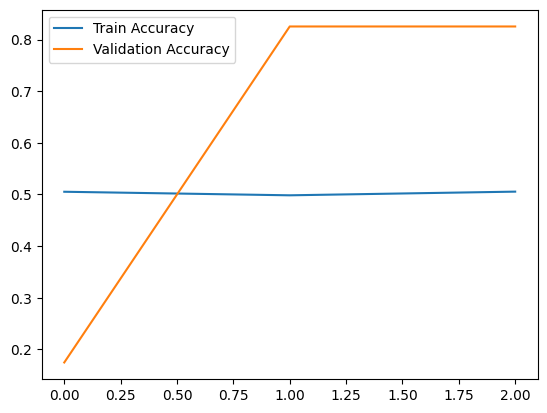

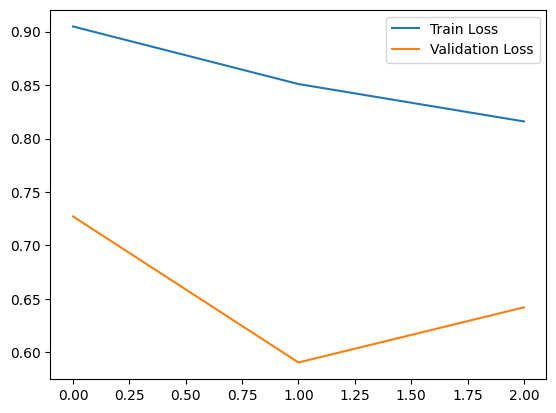

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [30]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Training Accuracy: 0.5055
Final Validation Accuracy: 0.8253


In [32]:
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8354 - loss: 0.5869
Test Accuracy: 0.8253


Class Distribution: target
0    0.821894
1    0.178106
Name: proportion, dtype: float64
Dataset Size: 17731 train | 3800 validation


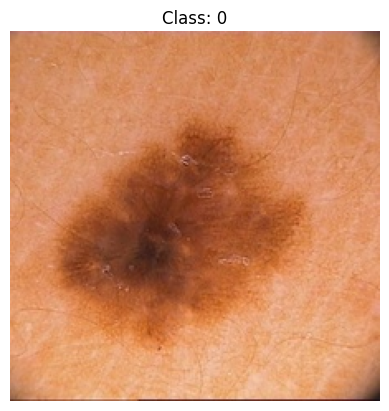

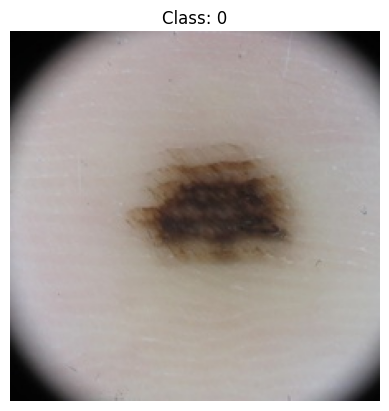

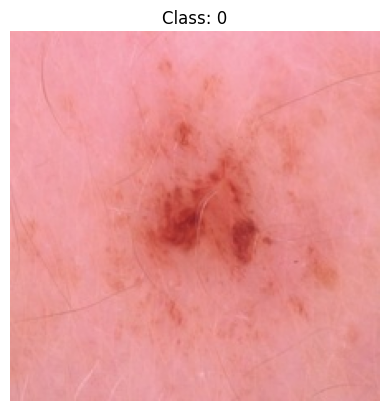

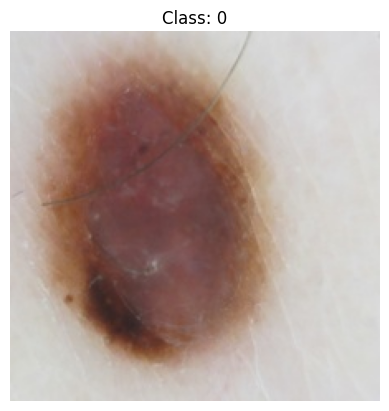

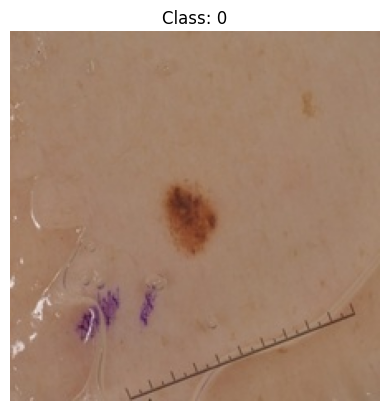

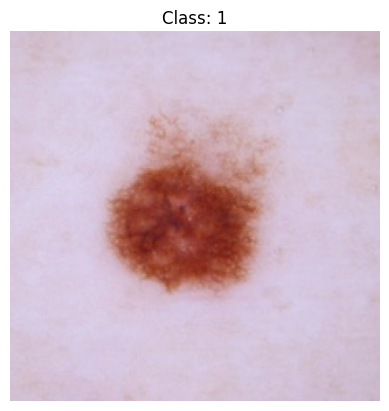

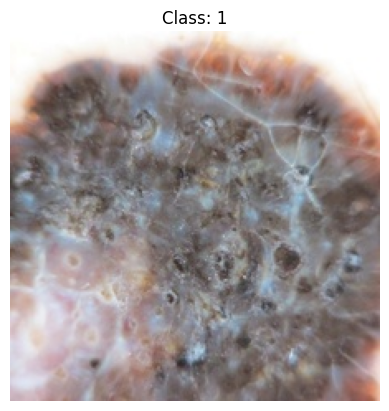

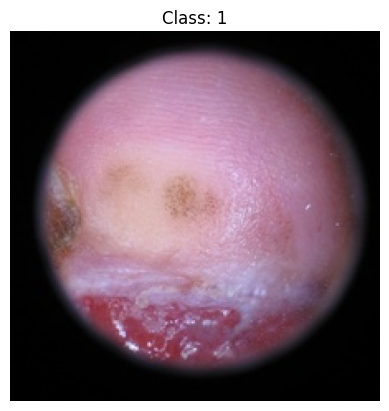

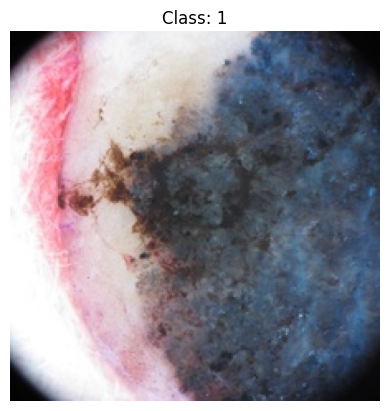

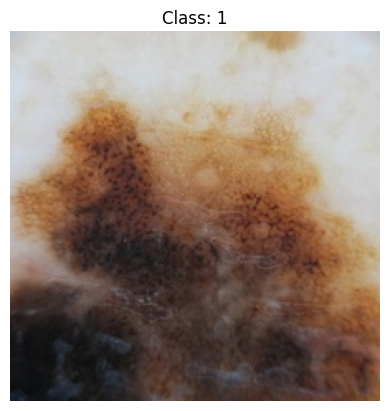

In [40]:
print("Class Distribution:", train_df['target'].value_counts(normalize=True))
print("Dataset Size:", len(train_df), "train |", len(val_df), "validation")

# View random samples per class
import random
samples = train_df.groupby('target').sample(5, random_state=42)
for idx, row in samples.iterrows():
    img = cv2.imread(row['path'])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Class: {row['target']}")
    plt.axis('off')
    plt.show()


In [41]:
from sklearn.metrics import classification_report

val_preds = (model.predict(val_generator) > 0.5).astype(int)
y_true = val_df['target'].astype(int).values[:len(val_preds)]

print(classification_report(y_true, val_preds))


119/119 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      3136
           1       0.00      0.00      0.00       664

    accuracy                           0.83      3800
   macro avg       0.41      0.50      0.45      3800
weighted avg       0.68      0.83      0.75      3800



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Step 1: Oversample Class 1 (Training Data)
python
Copy
Edit


In [46]:
import pandas as pd

# Oversample class 1 (minority) by duplicating its entries
class_0 = train_df[train_df.target == '0'].copy()
class_1 = train_df[train_df.target == '1'].copy()

# Oversample class 1 to match class 0 count
class_1_oversampled = class_1.sample(len(class_0), replace=True, random_state=42)

# Combine and shuffle
train_balanced = pd.concat([class_0, class_1_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print(train_balanced['target'].value_counts())

target
1    14573
0    14573
Name: count, dtype: int64


Step 2: Stratified Validation Split

In [47]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_balanced,
    test_size=0.15,
    stratify=train_balanced['target'],
    random_state=42
)

print("Train distribution:\n", train_df['target'].value_counts())
print("Validation distribution:\n", val_df['target'].value_counts())

Train distribution:
 target
1    12387
0    12387
Name: count, dtype: int64
Validation distribution:
 target
1    2186
0    2186
Name: count, dtype: int64


Step 3: ImageDataGenerators
python
Copy
Edit


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(rescale=1./255, rotation_range=30, horizontal_flip=True, zoom_range=0.2)
datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='target',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen_val.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='target',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 24774 validated image filenames belonging to 2 classes.
Found 4372 validated image filenames belonging to 2 classes.


 Step 4: Simpler CNN (Optional, Recommended)

In [49]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 5: Train with Class Weights + Callbacks

In [51]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 309s 399ms/step - accuracy: 0.7336 - loss: 0.5215 - val_accuracy: 0.7450 - val_loss: 0.5015 - learning_rate: 0.0010
Epoch 2/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 304s 392ms/step - accuracy: 0.7292 - loss: 0.5249 - val_accuracy: 0.7484 - val_loss: 0.4969 - learning_rate: 0.0010
Epoch 3/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 308s 397ms/step - accuracy: 0.7390 - loss: 0.5093 - val_accuracy: 0.7452 - val_loss: 0.5029 - learning_rate: 0.0010
Epoch 4/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 307s 396ms/step - accuracy: 0.7344 - loss: 0.5159 - val_accuracy: 0.7521 - val_loss: 0.4942 - learning_rate: 0.0010
Epoch 5/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 307s 397ms/step - accuracy: 0.7474 - loss: 0.5081 - val_accuracy: 0.7518 - val_loss: 0.4824 - learning_rate: 0.0010
Epoch 6/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 304s 392ms/step - accuracy: 0.7450 - loss: 0.5024 - val_accuracy: 0.7598 - val_loss: 0.4785 - learning_rate: 0.0010
Epoch 7/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 306s 395ms/step - accura

Step 6: Evaluate with F1-Score

In [53]:
from sklearn.metrics import classification_report
import numpy as np

y_true = val_df['target'].astype(int).values

y_pred = (model.predict(val_generator) > 0.5).astype(int).flatten()

print(classification_report(y_true[:len(y_pred)], y_pred, digits=4))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step
              precision    recall  f1-score   support

           0     0.5145    0.4954    0.5048      2186
           1     0.5135    0.5325    0.5228      2186

    accuracy                         0.5140      4372
   macro avg     0.5140    0.5140    0.5138      4372
weighted avg     0.5140    0.5140    0.5138      4372



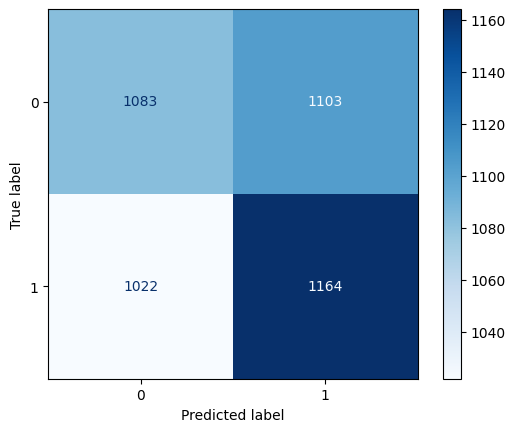

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true[:len(y_pred)], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


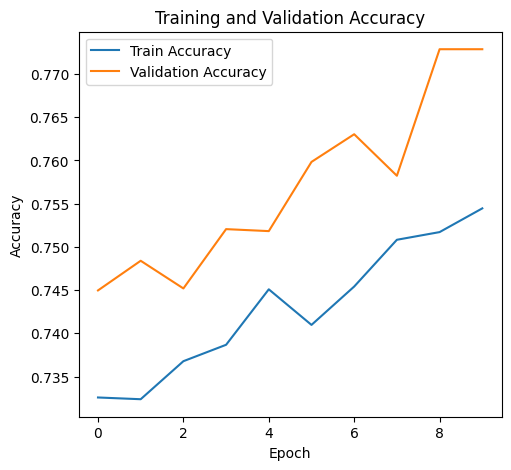

In [56]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


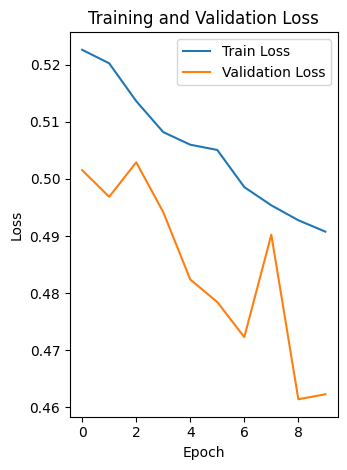

In [57]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.4f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.7736 - loss: 0.4559
Test Accuracy: 0.7729


In [62]:
best_train_acc = max(history.history['accuracy'])
print(f"Best Training Accuracy: {best_train_acc:.4f}")

Best Training Accuracy: 0.7545
